# Pythonで学ぶ制御工学 Part2

### 今日の目標
* 閉ループ系の安定性をPythonでチェックできる
* PID制御系の応答特性（時間・周波数）のグラフをPythonで描ける

In [430]:
run PIDGain.py

Loading BokehJS ...

interactive(children=(FloatSlider(value=0.1, description='kp', max=30.0, min=0.1, step=0.2), FloatSlider(value…

In [15]:
run PIDgain.py

Loading BokehJS ...

interactive(children=(FloatSlider(value=0.1, description='kp', max=20.0, min=0.1), FloatSlider(value=0.0, desc…

In [2]:
from control.matlab import *
import matplotlib.pyplot as plt
import numpy as np

### フィードバック系の安定性


$G_{yr}$などのフィードバック系を求めてpoleで極を計算する

ただし，$G_{ud}$ はインプロパーになることがあり，伝達関数をPython上で記述できない場合がある

P と C の間に不安定な極零相殺がないばあいには，$G_{yr}$の極を調べれば良い

In [2]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])

Gyr = feedback(P*C, 1)
print(Gyr.pole())

Gyd = -feedback(P*C, 1)
print(Gyd.pole())

Gur = minreal(P*feedback(1, P*C))
print(Gur.pole())

#Gud = C*feedback(1, P*C) #インプロパー
#print(Gud.pole())

[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]
[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]
2 states have been removed from the model
[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]


In [5]:
Info = stepinfo(Gyr, SettlingTimeThreshold=0.05)
print(Info)

{'RiseTime': 0.38134794663607546, 'SettlingTime': 2.526430146464, 'SettlingMin': 0.8889281055929367, 'SettlingMax': 1.2108759926728154, 'Overshoot': 21.096814935683064, 'Undershoot': 0.0, 'Peak': 1.2108759926728154, 'PeakTime': 0.8580328799311698, 'SteadyStateValue': 0.9999238983419472}


In [6]:
print(type(Info))
# 辞書形式

<class 'dict'>


In [3]:
[[Np]], [[Dp]] = tfdata(P)
[[Nc]], [[Dc]] = tfdata(C)

f1 = np.poly1d(Np)
f2 = np.poly1d(Nc)
g1 = np.poly1d(Dp)
g2 = np.poly1d(Dc)

print(np.roots( f1*f2 + g1*g2 ))

[-1.35300549+2.89375856j -1.35300549-2.89375856j -0.29398903+0.j        ]


### フィードバック系のステップ応答

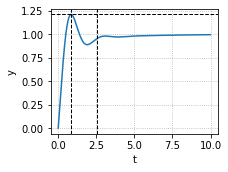

In [9]:
fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t,y)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.axvline(Info['PeakTime'], lw=1, ls='--', c='k')
ax.axhline(Info['Peak'], lw=1, ls='--', c='k')
ax.axvline(Info['SettlingTime'], lw=1, ls='--', c='k')
ax.grid(ls=':')

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

特性多項式を計算し，その根を求める

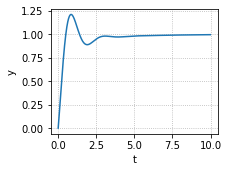

In [4]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])
Gyr = feedback(P*C, 1)

y,t = step(Gyr,np.arange(0, 10, 0.01))

fig, ax = plt.subplots(figsize=(3, 2.3))
ax.plot(t,y)
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.grid(ls=':')

### フィードバック系の周波数応答

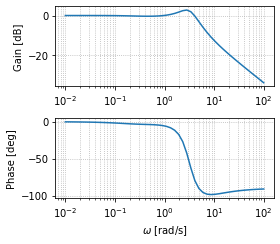

In [10]:
P = tf([0, 1],[1, 1 ,1])
C = tf([2, 10, 3],[1, 0])
Gyr = feedback(P*C, 1)

gain, phase, w = bode(Gyr, logspace(-2,2), Plot=False)

fig, ax = plt.subplots(2,1, figsize=(4, 3.5))
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
fig.tight_layout()

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

## ゲインチューニング
### ステップ応答法

ステップ応答の計測

In [3]:
# 台車系のモデル
a = 6.25
b = 4.36
P = tf([0, b], [1, a, 0])

y, t = step(P, np.arange(0, 1, 0.01))

# ある程度時間が経過したあとの応答を１次関数で近似する
yslice = y[40::]
tslice = t[40::]
p = np.polyfit(tslice, yslice, 1)
p

array([ 0.68493029, -0.10034948])

無定位系の応答

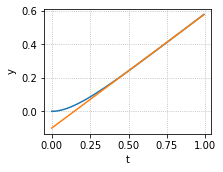

In [4]:
fig, ax = plt.subplots(figsize=(3, 2.3))
y, t = step(P, np.arange(0, 1, 0.01) )
ax.plot(t, y)
ax.plot(t, np.poly1d( p )(t))
ax.set_xlabel('t')
ax.set_ylabel('y')
ax.grid(ls=':')

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### 限界感度法

## 限界感度法

### 無駄時間要素

In [28]:
num_delay, den_delay = pade( 0.005, 1)
Pdelay = P * tf(num_delay, den_delay)
Pdelay


               -s + 400
--------------------------------------
0.01 s^3 + 4.015 s^2 + 6.981 s + 392.4

### チューニング

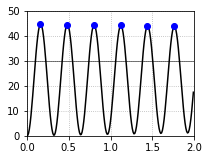

In [31]:
from scipy import signal

fig, ax = plt.subplots(figsize=(3, 2.3))

kp0 = 2.9
C = tf([0, kp0], [0, 1])
Gyr = feedback(Pdelay*C, 1)
y,t = step(Gyr, np.arange(0, 2, 0.01))

[maxId] = signal.argrelmax(y)

ax.plot(t, y*ref, color='k')
ax.plot(t[maxId], y[maxId]*ref, 'bo')

ax.axhline(ref, color='k', linewidth=0.5)    
ax.set_xlim(0, 2)
ax.set_ylim(0, 50)
ax.grid(ls=':')

#fig.savefig("tune_zn.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

### モデルマッチング

### 制御系設計の例題

### 制御系設計の例

In [24]:
g  = 9.81                # 重力加速度[m/s^2]
l  = 0.2                 # アームの長さ[m]
m  = 0.5                 # アームの質量[kg]
mu = 1.5e-2              # 粘性摩擦係数[kg*m^2/s]
J  = 1.0e-2              # 慣性モーメント[kg*m^2]

ref = 30

P = tf( [0,1], [J, mu, m*g*l] )

In [25]:
alpha1 = 2
alpha2 = 2
omega_n = 12

kp = J*alpha1*omega_n**2-m*g*l
ki = J*omega_n**3
kd = J*alpha2*omega_n - c

C1 = tf([kd, kp, ki], [1, 0])
C2 = tf([0, ki], [kd, kp, ki])

{'RiseTime': 0.19152485819152504,
 'SettlingTime': 0.4963296629963302,
 'SettlingMin': 0.9028806549649726,
 'SettlingMax': 1.0814649583429348,
 'Overshoot': 8.097897144500802,
 'Undershoot': 0.0,
 'Peak': 1.0814649583429348,
 'PeakTime': 0.40990990990991033,
 'SteadyStateValue': 1.0004495803440812}

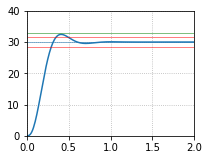

In [30]:
Gyz = feedback(P*C1, 1)

Td = np.arange(0, 2, 0.01)
r = 1*(Td>0)

#z, t, _ = lsim(C2, r, Td, 0)
#y, _, _ = lsim(Gyz, z, Td, 0)

fig, ax = plt.subplots(figsize=(3, 2.3))

y, t = step(Gyz*C2, Td)
ax.plot(t, y*ref, label='I-PD')

ax.axhline(ref, linewidth=0.5)
ax.axhline(ref*1.05, linewidth=0.5, c='r')  
ax.axhline(ref*0.95, linewidth=0.5, c='r')  
ax.axhline(ref*1.1, linewidth=0.5, c='g')  
ax.grid(ls=':')

ax.set_xlim(0, 2)
ax.set_ylim(0,40)

stepinfo(Gyz*C2, SettlingTimeThreshold=0.05)

#fig.savefig("test.pdf", transparent=True, bbox_inches="tight", pad_inches=0.0)

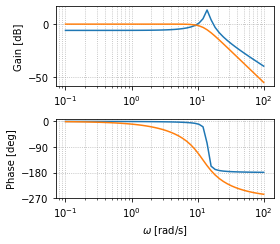

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P/(1+P), logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(C2*Gyz, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-270,-180,-90,0])

fig.tight_layout()

## モデルマッチング 

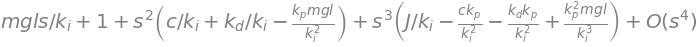

In [10]:
import sympy as sp
s = sp.Symbol('s')
kp, kd, ki = sp.symbols('k_p k_d k_i')
mgl, c, J = sp.symbols('mgl c J')
sp.init_printing()

G = (kp*s+ki)/(J*s**3 +(c+kd)*s**2 + (mgl + kp)*s + ki)
sp.series(1/G, s, 0, 4)

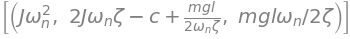

In [11]:
import sympy as sp
z, wn = sp.symbols('zeta omega_n')
kp, kd, ki = sp.symbols('k_p k_d k_i')
mgl,c,J = sp.symbols('mgl c J')
sp.init_printing()

f1 = mgl/ki-2*z/wn
f2 = (c+kd)/ki-mgl*kp/(ki**2)-1/(wn**2)
f3 = J/ki-kp*(c+kd)/(ki**2)+mgl*kp**2/(ki**3)
sp.solve([f1, f2, f3],[kp, kd, ki])

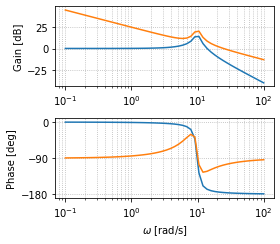

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(4, 3.5)) 

gain, phase, w = bode(P, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

gain, phase, w = bode(P*C1, logspace(-1,2), Plot=False)
ax[0].semilogx(w, 20*np.log10(gain))
ax[1].semilogx(w, phase*180/np.pi)

ax[0].grid(which="both", ls=':')
ax[0].set_ylabel('Gain [dB]')
ax[1].grid(which="both", ls=':')
ax[1].set_xlabel('$\omega$ [rad/s]')
ax[1].set_ylabel('Phase [deg]')
ax[1].set_ylim(-190,10)
ax[1].set_yticks([-180,-90,0])

fig.tight_layout()